In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### data

In [31]:
def read_files(train_path, test_path, sub_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    sub = pd.read_csv(sub_path)
    return train, test, sub

train, test, sub = read_files('/content/drive/My Drive/AIMS_Train.csv', '/content/drive/My Drive/AIMS_Test.csv', '/content/drive/My Drive/AIMS_SampleSubmission.csv')
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,NO,22,"Data:1000F=2GB,30d",1.0,0
1,3322a4900689f7f3cb14b8f9ea00778853f02d75,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,0
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,NO,8,"Data: 100 F=40MB,24H",3.0,0
3,98c44b62c33c6a1d9dbcf5e918868419f249c4a8,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NO,9,NaN,NaN,0


In [32]:
# # data description
# desc = pd.read_csv('/content/VariableDefinitions.csv')
# desc

In [33]:
# safe to do 250 roughly kwa zote (explanation kwa section ya outliers kule chini)
train = train[(train.REVENUE < 200000)& (train.MONTANT < 210000)]

In [34]:
# categorical + continous  + discrete
categorical = []
continous = []
discrete = []

for col in train.columns:
    if train[col].dtypes in ['int16', 'int32', 'int64']:
        discrete.append(col)
    elif train[col].dtype in ['float32', 'float16', 'float64']:
        continous.append(col)
    else:
        categorical.append(col)

ids = test[['user_id']]
target = train[['CHURN']]
cols = categorical + continous + discrete
cols.remove('CHURN')
train = train[cols]
test = test[cols]
features = pd.concat([train, test])
print(features.shape)
features.head()

(526514, 18)


,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK,REGULARITY
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,K > 24 month,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,1.0,22
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,K > 24 month,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,3.0,8
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,NaN,K > 24 month,NO,NaN,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NaN,9
5,09a37c5e08a0dc00c5c61ab6198b351078115a1f,NaN,K > 24 month,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,NaN,6.0,15.0,NaN,NaN,NaN,2.0,37
10,cf44809a7c6f59535233d5d60bbc1fd1ec28b0b0,THIES,K > 24 month,NO,"Data:1000F=2GB,30d",2100.0,3.0,2089.0,696.0,4.0,3351.0,1.0,43.0,NaN,NaN,NaN,2.0,55


### Nulls

In [35]:
# null values
n = test.isna().sum()
m = train.isna().sum()
a = pd.DataFrame(columns = ['train', 'test'])
a['test'] = (n/(test.shape[0]))*100
a['train'] = (m/(train.shape[0]))*100
a

,train,test
user_id,0.000000,0.000000
REGION,21.088500,39.422824
TENURE,0.000000,0.000000
MRG,0.000000,0.000000
TOP_PACK,9.538252,41.751872
MONTANT,0.000000,34.990968
FREQUENCE_RECH,0.000000,34.990968
REVENUE,0.000000,33.483576
ARPU_SEGMENT,0.000000,33.483576
FREQUENCE,0.000000,33.483576


In [36]:
features = features.drop(['TIGO', 'ZONE1', 'ZONE2'], axis = 1)  # high percentage of missing values + high correlation

In [37]:
features.REGION = features['REGION'].fillna(features['REGION'].mode()[0])
features.DATA_VOLUME.fillna((features['DATA_VOLUME'].mode()[0]), inplace=True)
features.REVENUE.fillna((features['REVENUE'].mean()), inplace=True)
features.MONTANT.fillna((features['MONTANT'].mean()), inplace=True)  #fill after revenue w/regression imputation
features.ARPU_SEGMENT = features['ARPU_SEGMENT'].fillna(features['ARPU_SEGMENT'].mode()[0])
# features.ORANGE = features['ORANGE'].fillna(features['ORANGE'].mode()[0]) ###
features.FREQUENCE_RECH = features['FREQUENCE_RECH'].fillna(features['FREQUENCE_RECH'].mode()[0]) ###
features.FREQUENCE = features['FREQUENCE'].fillna(features['FREQUENCE'].mode()[0]) ###
features.FREQ_TOP_PACK = features['FREQ_TOP_PACK'].fillna(features['FREQ_TOP_PACK'].mode()[0]) ###
features.TOP_PACK = features['TOP_PACK'].fillna(features['TOP_PACK'].mode()[0])
# features.FREQUENCE.fillna(0, inplace=True)
features.ON_NET.fillna(0, inplace=True)
features.ORANGE.fillna(0, inplace=True)
features.isna().sum()


user_id           0
REGION            0
TENURE            0
MRG               0
TOP_PACK          0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
FREQ_TOP_PACK     0
REGULARITY        0
dtype: int64

### Feature Generation

In [38]:
features.MONTANT.describe()

count    526514.000000
mean       5604.338802
std        6872.909962
min          10.000000
25%        1200.000000
50%        3600.000000
75%        7000.000000
max      201500.000000
Name: MONTANT, dtype: float64

In [39]:
# decile classes for montant(amount recharged)
features['montant_rank'] = pd.cut(features['MONTANT'], 10, labels = False) 

# decile classes for revenue
features['revenue_rank'] = pd.cut(features['REVENUE'], 10, labels = False) 

# both (call to orange  + call international)
features['both'] = 0
features.loc[(features['ORANGE'] > 0) & (features['ON_NET'] > 0) , 'both'] = 1

# decile classes ya top pack based on value counts
z = features['TOP_PACK'].value_counts()
z1 = z.to_dict() #converts to dictionary
features['Count_Column'] = features['TOP_PACK'].map(z1) 
features['pack_rank'] = pd.cut(features['Count_Column'], 10, labels = False)
features = features.drop(['Count_Column'], axis = 1)

# remaining income after airtime purchase(montant)
features['income_bal'] = features['REVENUE'] - features['MONTANT']

# customers fraction of income that goes into airtime purchase
features['credit_fraction'] = features['MONTANT'] / features['REVENUE']

# tenure averages (avg of tenure months)
features['TENURE_avg'] = features['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2,
                                         'G 12-15 month':(12+15)/2, 'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2,
                                         'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})

# tenure mapping
features['TENURE'] = features['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})


# no of times refilling was done/duration in the network
features['refill_dur_rate'] = features['TENURE_avg'] / features['FREQUENCE_RECH']

# avg amount per refill
features['total_montant'] = features['MONTANT'] * features['FREQUENCE_RECH']

# no of times refilling was done/no of times customer was active
features['refill_rate'] = features['TENURE_avg'] / features['REGULARITY']

# income times number of times income's been made
features['total_revenue'] = features['REVENUE'] * features['FREQUENCE']

#regularity / freq top pack (times customer's activated top pck / no of times customer's been active)
features['top_pack_ratio'] = features['FREQUENCE_RECH']/features['REGULARITY']

#regularity /FREQUENCE_RECH  (times customer's recharged / no of times customer's been active)
features['refill_times'] = features['FREQ_TOP_PACK']/features['REGULARITY']

# no of times he's been active / duration in network
features['ten_reg'] = features['REGULARITY'] / features['TENURE_avg']

# more feature generation
features['total_ratio'] = features['total_montant'] / features['total_revenue'] #totals ratio
features['freq_rech'] = features['FREQUENCE_RECH'] / features['FREQUENCE']   #total refills/total income counts

features['freq_ratios'] = features['FREQUENCE'] / features['FREQUENCE_RECH']  #income count/refill count
features['income_ratio'] = features['REVENUE'] / features['FREQUENCE'] #income/income count
features['refill_ratio'] = features['MONTANT'] / features['FREQUENCE_RECH'] #refill/refill count

print(features.shape)
features.head()

(526514, 34)


,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,24.0,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,24.0,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,DAKAR,24.0,NO,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0
5,09a37c5e08a0dc00c5c61ab6198b351078115a1f,DAKAR,24.0,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0
10,cf44809a7c6f59535233d5d60bbc1fd1ec28b0b0,THIES,24.0,NO,"Data:1000F=2GB,30d",2100.0,3.0,2089.0,696.0,4.0,3351.0,1.0,43.0,2.0,55,0,0,1,1,-11.0,1.005266,25.5,8.5,6300.0,0.463636,8356.0,0.054545,0.036364,2.156863,0.753949,0.750000,1.333333,522.250000,700.0


In [40]:
# generating new features based on region
region = features.groupby('REGION').mean()
# region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean')

features = pd.merge(features, region, on='REGION', how = 'left')
for col in cols:
    features[col+'_freq'] = features[col].map(features[col].value_counts().to_dict())/len(features)

print(features.shape)
features.head()

(526514, 94)


,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,...,refill_rate_reg_mean,total_revenue_reg_mean,top_pack_ratio_reg_mean,refill_times_reg_mean,ten_reg_reg_mean,total_ratio_reg_mean,freq_rech_reg_mean,freq_ratios_reg_mean,income_ratio_reg_mean,refill_ratio_reg_mean,TENURE_reg_mean_freq,MONTANT_reg_mean_freq,FREQUENCE_RECH_reg_mean_freq,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,24.0,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,...,1.245750,135634.894718,0.257871,0.197670,1.563080,2.444535,0.791966,1.517707,543.054621,698.062700,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385
1,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,24.0,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,2.723058,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210
2,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,DAKAR,24.0,NO,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,2.723058,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210
3,09a37c5e08a0dc00c5c61ab6198b351078115a1f,DAKAR,24.0,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,2.723058,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.5512

In [41]:
# lets explore the top_pack variable

tops_list = features.TOP_PACK.to_list()
# tops_list = a.tolist()
print(features.TOP_PACK.nunique())
print(len(tops_list))
# a

117
526514


In [2]:
first = []
for element in tops_list:
    a = element.split('_')
    a = a[0]
    first.append(a)

name = []
for element in first:
    a = element.split(':')
    a = a[0]
    name.append(a)

names = []
for element in name:
    a = element.split('=')
    a = a[0]
    names.append(a)


n = []
for element in names:
    a = element.split('(')
    a = a[0]
    n.append(a)

m = []
for element in n:
    a = element.split(' ')
    a = a[0]
    m.append(a)

# len(m)
# m

In [43]:
features['top_list_class'] = m
print(features.top_list_class.nunique())
# df.loc[df['First Season'] > 1990, 'First Season'] = 1
features.loc[features['top_list_class'] == 'On', 'top_list_class'] = 'On-net'
features.top_list_class.nunique()

40


39

In [44]:
features.head()

,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,...,total_revenue_reg_mean,top_pack_ratio_reg_mean,refill_times_reg_mean,ten_reg_reg_mean,total_ratio_reg_mean,freq_rech_reg_mean,freq_ratios_reg_mean,income_ratio_reg_mean,refill_ratio_reg_mean,TENURE_reg_mean_freq,MONTANT_reg_mean_freq,FREQUENCE_RECH_reg_mean_freq,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq,top_list_class
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,24.0,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,...,135634.894718,0.257871,0.197670,1.563080,2.444535,0.791966,1.517707,543.054621,698.062700,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,Data
1,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,24.0,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,Data
2,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,DAKAR,24.0,NO,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net
3,09a37c5e08a0dc00c5c61ab6198b351078115a1f,DAKAR,24.0,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,160186.686234,0.355085,0.274686,1.314439,7.896401,0.824065,1.433996,1008.878620,1158.514026,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.5

In [45]:
# log features
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['FREQUENCE', 'MONTANT', 'REVENUE', 'DATA_VOLUME', 'FREQUENCE_RECH', 'REGULARITY']

features = logs(features, log_features)

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['FREQUENCE', 'MONTANT', 'REVENUE', 'DATA_VOLUME', 'FREQUENCE_RECH', 'REGULARITY']

features = squares(features, squared_features)
print(features.shape)
features.head()

(526514, 107)


,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,...,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq,top_list_class,FREQUENCE_log,MONTANT_log,REVENUE_log,DATA_VOLUME_log,FREQUENCE_RECH_log,REGULARITY_log,FREQUENCE_sq,MONTANT_sq,REVENUE_sq,DATA_VOLUME_sq,FREQUENCE_RECH_sq,REGULARITY_sq
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,24.0,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,...,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,Data,0.698135,6.908765,6.898725,4.585070,0.698135,3.135929,1.0,1000000.0,980100.0,9409.0,1.0,484
1,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,24.0,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,Data,2.080691,6.552522,6.918705,6.340377,1.793425,2.198335,49.0,490000.0,1020100.0,320356.0,25.0,64
2,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,DAKAR,24.0,NO,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.388791,8.006704,8.005037,0.009950,1.388791,2.303585,9.0,9000000.0,8970025.0,0.0,9.0,81
3,09a37c5e08a0dc00c5c61ab6198b351078115a1f,DAKAR,24.0,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.611436,7.090918,7.090085,0.009950,1.388791,3.637849,16.0,1440000.0,1

In [46]:
features.columns

Index(['user_id', 'REGION', 'TENURE', 'MRG', 'TOP_PACK', 'MONTANT',
       'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       ...
       'REVENUE_log', 'DATA_VOLUME_log', 'FREQUENCE_RECH_log',
       'REGULARITY_log', 'FREQUENCE_sq', 'MONTANT_sq', 'REVENUE_sq',
       'DATA_VOLUME_sq', 'FREQUENCE_RECH_sq', 'REGULARITY_sq'],
      dtype='object', length=107)

### Distributions + outliers

In [47]:
features.dtypes

user_id               object
REGION                object
TENURE               float64
MRG                   object
TOP_PACK              object
                      ...   
MONTANT_sq           float64
REVENUE_sq           float64
DATA_VOLUME_sq       float64
FREQUENCE_RECH_sq    float64
REGULARITY_sq          int64
Length: 107, dtype: object

In [48]:
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


 mu = 5677.26 and sigma = 6961.15



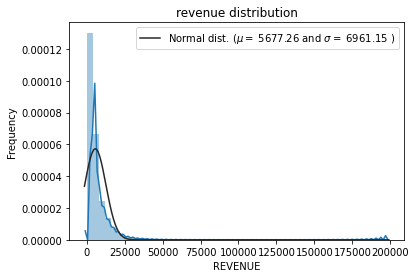

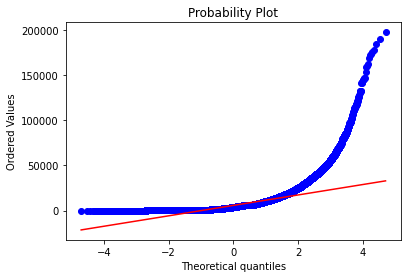

In [49]:
# total_rtt
sns.distplot(features['REVENUE'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(features['REVENUE'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('revenue distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(features['REVENUE'], plot=plt)
plt.show()

Damn we got a skewed dist + outliers.


 mu = 5604.34 and sigma = 6872.90



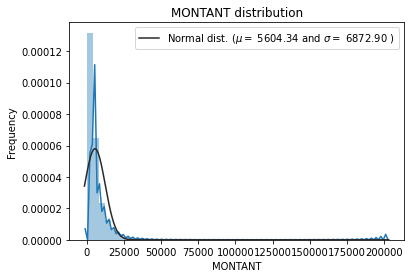

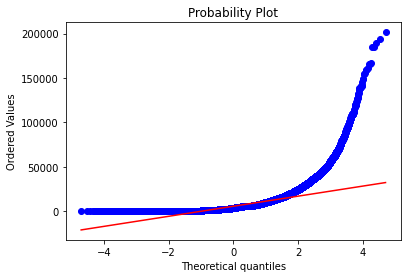

In [50]:
# total_rtt
sns.distplot(features['MONTANT'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(features['MONTANT'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MONTANT distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(features['MONTANT'], plot=plt)
plt.show()


 mu = 2412.38 and sigma = 10641.14



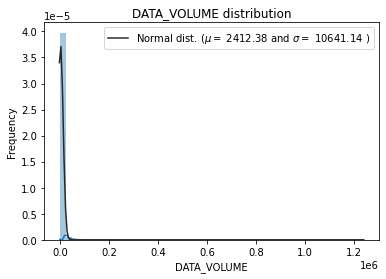

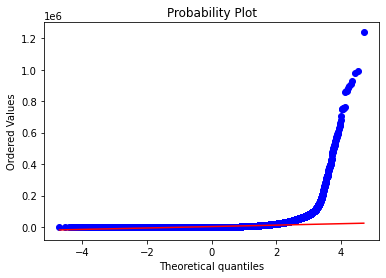

In [51]:
# total_rtt
sns.distplot(features['DATA_VOLUME'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(features['DATA_VOLUME'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('DATA_VOLUME distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(features['DATA_VOLUME'], plot=plt)
plt.show()

Its like all these guys have outliers. 

But our interest in terms of outliers lies with the 2 cols: revenue and motant given the rest are mostly 'frequencies.'

In [53]:
features.dtypes

user_id               object
REGION                object
TENURE               float64
MRG                   object
TOP_PACK              object
                      ...   
MONTANT_sq           float64
REVENUE_sq           float64
DATA_VOLUME_sq       float64
FREQUENCE_RECH_sq    float64
REGULARITY_sq          int64
Length: 107, dtype: object

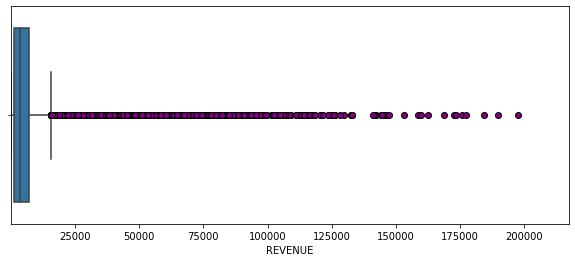

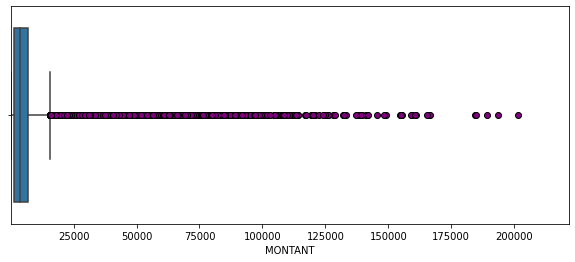

In [56]:
plt.figure(figsize=(10,4))
plt.xlim(features.REVENUE.min(), features.REVENUE.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=features.REVENUE, flierprops=flierprops)


plt.figure(figsize=(10,4))
plt.xlim(features.MONTANT.min(), features.MONTANT.max()*1.1)
sns.boxplot(x=features.MONTANT, flierprops=flierprops)

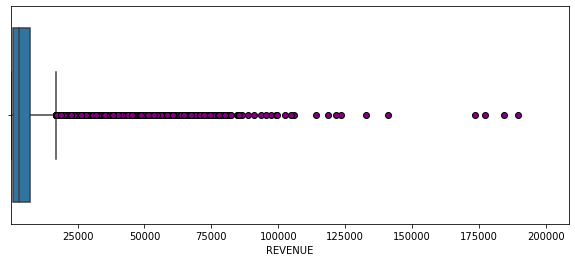

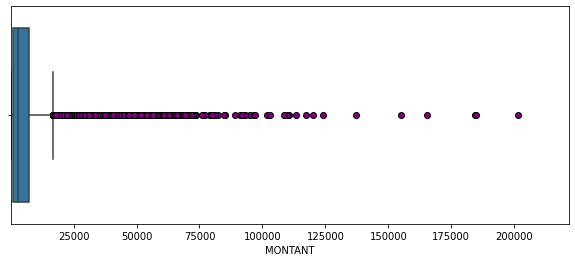

In [57]:
plt.figure(figsize=(10,4))
plt.xlim(test.REVENUE.min(), test.REVENUE.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=test.REVENUE, flierprops=flierprops)


plt.figure(figsize=(10,4))
plt.xlim(test.MONTANT.min(), test.MONTANT.max()*1.1)
sns.boxplot(x=test.MONTANT, flierprops=flierprops)

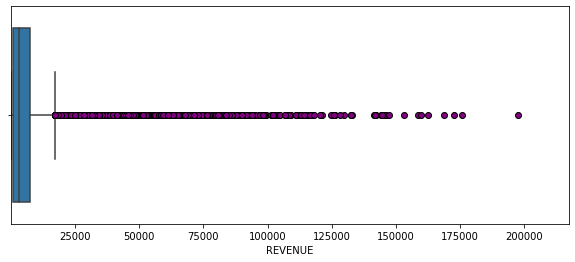

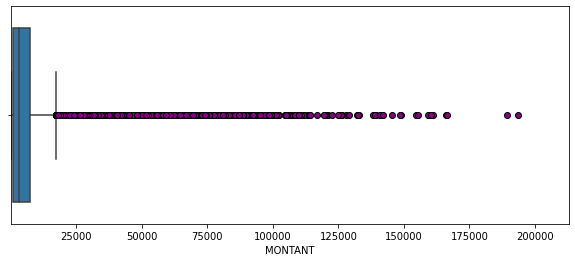

In [58]:
plt.figure(figsize=(10,4))
plt.xlim(train.REVENUE.min(), train.REVENUE.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.REVENUE, flierprops=flierprops)


plt.figure(figsize=(10,4))
plt.xlim(train.MONTANT.min(), train.MONTANT.max()*1.1)
sns.boxplot(x=train.MONTANT, flierprops=flierprops)

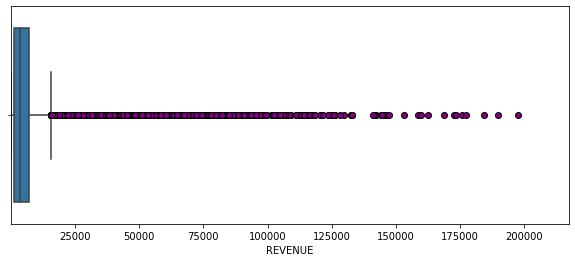

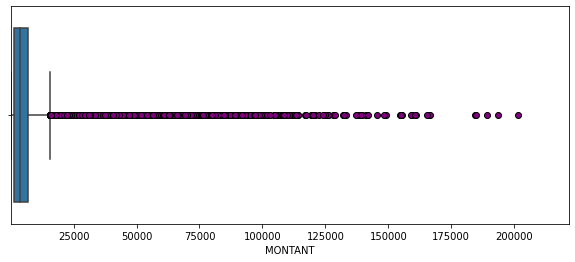

In [65]:
plt.figure(figsize=(10,4))
plt.xlim(features.REVENUE.min(), features.REVENUE.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=features.REVENUE, flierprops=flierprops)


plt.figure(figsize=(10,4))
plt.xlim(features.MONTANT.min(), features.MONTANT.max()*1.1)
sns.boxplot(x=features.MONTANT, flierprops=flierprops)

In [66]:
features.head()

,user_id,REGION,TENURE,MRG,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,...,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq,top_list_class,FREQUENCE_log,MONTANT_log,REVENUE_log,DATA_VOLUME_log,FREQUENCE_RECH_log,REGULARITY_log,FREQUENCE_sq,MONTANT_sq,REVENUE_sq,DATA_VOLUME_sq,FREQUENCE_RECH_sq,REGULARITY_sq
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,24.0,NO,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,...,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,Data,0.698135,6.908765,6.898725,4.585070,0.698135,3.135929,1.0,1000000.0,980100.0,9409.0,1.0,484
1,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,24.0,NO,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,Data,2.080691,6.552522,6.918705,6.340377,1.793425,2.198335,49.0,490000.0,1020100.0,320356.0,25.0,64
2,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,DAKAR,24.0,NO,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.388791,8.006704,8.005037,0.009950,1.388791,2.303585,9.0,9000000.0,8970025.0,0.0,9.0,81
3,09a37c5e08a0dc00c5c61ab6198b351078115a1f,DAKAR,24.0,NO,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.611436,7.090918,7.090085,0.009950,1.388791,3.637849,16.0,1440000.0,1

### further preprocessing

In [67]:
# categoricals
features = features.drop(['user_id', 'MRG', 'REGION'], axis = 1)
features.head()

,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,DATA_VOLUME_reg_mean,ON_NET_reg_mean,ORANGE_reg_mean,...,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq,top_list_class,FREQUENCE_log,MONTANT_log,REVENUE_log,DATA_VOLUME_log,FREQUENCE_RECH_log,REGULARITY_log,FREQUENCE_sq,MONTANT_sq,REVENUE_sq,DATA_VOLUME_sq,FREQUENCE_RECH_sq,REGULARITY_sq
0,24.0,"Data:1000F=2GB,30d",1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,1066.782427,306.809551,85.725397,...,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,Data,0.698135,6.908765,6.898725,4.585070,0.698135,3.135929,1.0,1000000.0,980100.0,9409.0,1.0,484
1,24.0,"Data: 100 F=40MB,24H",700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,Data,2.080691,6.552522,6.918705,6.340377,1.793425,2.198335,49.0,490000.0,1020100.0,320356.0,25.0,64
2,24.0,All-net 500F=2000F;5d,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.388791,8.006704,8.005037,0.009950,1.388791,2.303585,9.0,9000000.0,8970025.0,0.0,9.0,81
3,24.0,All-net 500F=2000F;5d,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,All-net,1.611436,7.090918,7.090085,0.009950,1.388791,3.637849,16.0,1440000.0,1437601.0,0.0,9.0,1369
4,24.0,"Data

In [70]:
indices = []
for col in ['TOP_PACK', 'top_list_class']:
    i = features.columns.get_loc(col)
    indices.append(i)

from sklearn.preprocessing import LabelEncoder
for col in indices:
    x = features.iloc[:, col].values
    x = x.reshape(-1,1)
    encoder = LabelEncoder()
    encoder = encoder.fit(x)
    x = encoder.transform(x)
    features.iloc[:, col] = x

features.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,FREQ_TOP_PACK,REGULARITY,montant_rank,revenue_rank,both,pack_rank,income_bal,credit_fraction,TENURE_avg,refill_dur_rate,total_montant,refill_rate,total_revenue,top_pack_ratio,refill_times,ten_reg,total_ratio,freq_rech,freq_ratios,income_ratio,refill_ratio,TENURE_reg_mean,MONTANT_reg_mean,FREQUENCE_RECH_reg_mean,REVENUE_reg_mean,ARPU_SEGMENT_reg_mean,FREQUENCE_reg_mean,DATA_VOLUME_reg_mean,ON_NET_reg_mean,ORANGE_reg_mean,...,REVENUE_reg_mean_freq,ARPU_SEGMENT_reg_mean_freq,FREQUENCE_reg_mean_freq,DATA_VOLUME_reg_mean_freq,ON_NET_reg_mean_freq,ORANGE_reg_mean_freq,FREQ_TOP_PACK_reg_mean_freq,REGULARITY_reg_mean_freq,montant_rank_reg_mean_freq,revenue_rank_reg_mean_freq,both_reg_mean_freq,pack_rank_reg_mean_freq,income_bal_reg_mean_freq,credit_fraction_reg_mean_freq,TENURE_avg_reg_mean_freq,refill_dur_rate_reg_mean_freq,total_montant_reg_mean_freq,refill_rate_reg_mean_freq,total_revenue_reg_mean_freq,top_pack_ratio_reg_mean_freq,refill_times_reg_mean_freq,ten_reg_reg_mean_freq,total_ratio_reg_mean_freq,freq_rech_reg_mean_freq,freq_ratios_reg_mean_freq,income_ratio_reg_mean_freq,refill_ratio_reg_mean_freq,top_list_class,FREQUENCE_log,MONTANT_log,REVENUE_log,DATA_VOLUME_log,FREQUENCE_RECH_log,REGULARITY_log,FREQUENCE_sq,MONTANT_sq,REVENUE_sq,DATA_VOLUME_sq,FREQUENCE_RECH_sq,REGULARITY_sq
0,24.0,28,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,0.0,1.0,22,0,0,0,1,-10.0,1.010101,25.5,25.5,1000.0,1.159091,990.0,0.045455,0.045455,0.862745,1.010101,1.000000,1.000000,990.000000,1000.0,23.530310,4968.500347,10.277037,5038.935172,1630.046250,13.014489,1066.782427,306.809551,85.725397,...,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,0.016385,8,0.698135,6.908765,6.898725,4.585070,0.698135,3.135929,1.0,1000000.0,980100.0,9409.0,1.0,484
1,24.0,24,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,3.0,8,0,0,1,1,310.0,0.693069,25.5,5.1,3500.0,3.187500,7070.0,0.625000,0.375000,0.313725,0.495050,0.714286,1.400000,144.285714,140.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,8,2.080691,6.552522,6.918705,6.340377,1.793425,2.198335,49.0,490000.0,1020100.0,320356.0,25.0,64
2,24.0,13,3000.0,3.0,2995.0,998.0,3.0,0.0,0.0,33.0,1.0,9,0,0,0,9,-5.0,1.001669,25.5,8.5,9000.0,2.833333,8985.0,0.333333,0.111111,0.352941,1.001669,1.000000,1.000000,998.333333,1000.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,6,1.388791,8.006704,8.005037,0.009950,1.388791,2.303585,9.0,9000000.0,8970025.0,0.0,9.0,81
3,24.0,13,1200.0,3.0,1199.0,400.0,4.0,0.0,6.0,15.0,2.0,37,0,0,1,9,-1.0,1.000834,25.5,8.5,3600.0,0.689189,4796.0,0.081081,0.054054,1.450980,0.750626,0.750000,1.333333,299.750000,400.0,23.658480,5837.748957,10.629516,5918.656636,1785.966808,13.164279,3181.860602,180.106674,77.299490,...,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,0.551210,6,1.611436,7.090918,7.090085,0.009950,1.388791,3.637849,16.0,1440000.0,1437601.0,0.0,9.0,1369
4,24.0,28,2100.0,3.0,2089.0,696.0,4.0,3351.0,1.0,43.0,2.0,55,0,0,1,1,-11.0,1.005266,25.5,8.5,6300.0,0.4636

In [71]:
# features = pd.get_dummies(features, columns = ['TOP_PACK', 'top_list_class'], drop_first = True)
# print(features.shape)
# features.head()

In [72]:
# numericals = []
# for col in features.columns:
#     if features[col].dtype in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
#         numerical.append(col)

# numericals

In [73]:
# # scaling
# from sklearn.preprocessing import StandardScaler, RobustScaler #robust is better in the presence of outliers
# def scaler(data):
#     indices = []
#     for col in features.columns:
#         k = data.columns.get_loc(col)
#         indices.append(k)

#     for col in indices:
#         x = data.iloc[:, col].values
#         x = x.reshape(-1,1)
#         imputer = RobustScaler()
#         imputer = imputer.fit(x)
#         x = imputer.transform(x)
#         data.iloc[:, col] = x  

#     return data

# features = scaler(features)
# features.head()

### Modeling

In [74]:
X = features.iloc[:len(train), :]
x_test = features.iloc[len(train):, :]
y = target
train_set = pd.concat([X, y], axis=1)

print('x train', X.shape)
print('y train', y.shape)
print('train set', train_set.shape)
print('x test', x_test.shape)

x train (412476, 104)
y train (412476, 1)
train set (561956, 105)
x test (114038, 104)


In [76]:
# modelling
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score

#stratified
cv = StratifiedKFold(n_splits=10, random_state=42)
def overall__stratified_score(model, x_train, y_train):
    accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv = cv)
    return accuracy.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


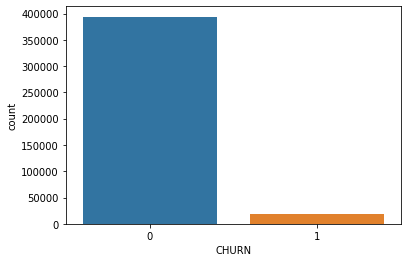

In [77]:
sns.countplot(target.CHURN)

### Stratified training

We use StratifiedKFold to split our train set into 5 folds, select one fold as validation set and train model with early stopping using the rest 4 folds as a training set. Then we use this model to predict outcomes for test set and record the predictions. Repeat 5 times, so every fold is validation set one time. Then we calculate average of predictions (here we use the fact that Target is in fact ordered and can be treated as numeric, so averaging is possible and looks reasonable).

In [191]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
lgb = LGBMClassifier()
predicts = []
for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=30)
    predicts.append(lgb.predict_proba(x_test))

###


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.168571
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.161163
[3]	valid_0's binary_logloss: 0.155929
[4]	valid_0's binary_logloss: 0.151928
[5]	valid_0's binary_logloss: 0.148776
[6]	valid_0's binary_logloss: 0.146196
[7]	valid_0's binary_logloss: 0.14406
[8]	valid_0's binary_logloss: 0.142273
[9]	valid_0's binary_logloss: 0.140749
[10]	valid_0's binary_logloss: 0.139471
[11]	valid_0's binary_logloss: 0.138352
[12]	valid_0's binary_logloss: 0.13738
[13]	valid_0's binary_logloss: 0.136556
[14]	valid_0's binary_logloss: 0.135841
[15]	valid_0's binary_logloss: 0.13521
[16]	valid_0's binary_logloss: 0.134674
[17]	valid_0's binary_logloss: 0.134195
[18]	valid_0's binary_logloss: 0.133758
[19]	valid_0's binary_logloss: 0.133409
[20]	valid_0's binary_logloss: 0.133071
[21]	valid_0's binary_logloss: 0.132775
[22]	valid_0's binary_logloss: 0.132528
[23]	valid_0's binary_logloss: 0.132277
[24]	valid_0's binary_logloss:

In [214]:
predicts
a = predicts[0]
b = predicts[1]
c = predicts[2]
d = predicts[3]
e = predicts[4]

a = a[:,1]
b = b[:,1]
c = c[:,1]
d = d[:,1]
e = e[:,1]

f = pd.DataFrame(columns = ['a', 'b', 'c', 'd', 'e'])
f['a'] = a
f['b'] = b
f['c'] = c
f['d'] = d
f['e'] = e

col = f.loc[: , "a":"e"]
f['CHURN'] = col.mean(axis=1)
f['user_id'] = ids
f = f.drop(['a', 'b', 'c', 'd', 'e'], axis = 1)
f = f[['user_id',  'CHURN']]
f.to_csv('fold.csv', index = False)
print(f.shape)
f.head()

(114038, 2)


,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0.006718
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0.053874
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0.000592
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0.016420
4,96c6a822243654ae1fe5f5f887089681f806cb46,0.029352


In [222]:
np.mean(np.array([a,b, c]), axis = 0).shape

(114038,)

### Stratified Stacking

In [ ]:
# look into overfitting
# feature selection
# stacking the 3. (xgb + cat + lgb)
# tuning
# stacking

In [84]:
from lightgbm import LGBMClassifier
kf = StratifiedKFold(n_splits=5, shuffle=True)
lgb = LGBMClassifier()
lgb_train_preds = []
lgb_predicts = []
for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=30)
    lgb_predicts.append(lgb.predict_proba(x_test)[:,1])
    lgb_train_preds.append(lgb.predict_proba(X)[:,1])


#     a = lgb_predicts[0]
#     b = lgb_predicts[1]
#     c = lgb_predicts[2]
#     d = lgb_predicts[3]
#     e = lgb_predicts[4]

#     a = a[:,1]
#     b = b[:,1]
#     c = c[:,1]
#     d = d[:,1]
#     e = e[:,1]
#     global lgb_pred
#     lgb_pred = np.mean(np.array([a,b, c, d, e]), axis = 0)

# lgb_pred

###


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.168413
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.160926
[3]	valid_0's binary_logloss: 0.155612
[4]	valid_0's binary_logloss: 0.151589
[5]	valid_0's binary_logloss: 0.148388
[6]	valid_0's binary_logloss: 0.145787
[7]	valid_0's binary_logloss: 0.143653
[8]	valid_0's binary_logloss: 0.141845
[9]	valid_0's binary_logloss: 0.140334
[10]	valid_0's binary_logloss: 0.139029
[11]	valid_0's binary_logloss: 0.137925
[12]	valid_0's binary_logloss: 0.136989
[13]	valid_0's binary_logloss: 0.136152
[14]	valid_0's binary_logloss: 0.135415
[15]	valid_0's binary_logloss: 0.134786
[16]	valid_0's binary_logloss: 0.134218
[17]	valid_0's binary_logloss: 0.13375
[18]	valid_0's binary_logloss: 0.133321
[19]	valid_0's binary_logloss: 0.132965
[20]	valid_0's binary_logloss: 0.132619
[21]	valid_0's binary_logloss: 0.132352
[22]	valid_0's binary_logloss: 0.132108
[23]	valid_0's binary_logloss: 0.131902
[24]	valid_0's binary_loglos

In [83]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat_train_preds = []
cat_predicts = []
for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    cat.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=30, use_best_model=True)
    cat_predicts.append(cat.predict_proba(x_test)[:,1])
    cat_train_preds.append(cat.predict_proba(X)[:,1])

#     a = cat_predicts[0]
#     b = cat_predicts[1]
#     c = cat_predicts[2]
#     d = cat_predicts[3]
#     e = cat_predicts[4]

#     a = a[:,1]
#     b = b[:,1]
#     c = c[:,1]
#     d = d[:,1]
#     e = e[:,1]
#     global cat_pred
#     cat_pred = np.mean(np.array([a,b, c, d, e]), axis = 0)

# cat_pred

###
Learning rate set to 0.132732
0:	learn: 0.4715658	test: 0.4717901	best: 0.4717901 (0)	total: 313ms	remaining: 5m 12s
1:	learn: 0.3344092	test: 0.3347460	best: 0.3347460 (1)	total: 547ms	remaining: 4m 33s
2:	learn: 0.2570661	test: 0.2573882	best: 0.2573882 (2)	total: 775ms	remaining: 4m 17s
3:	learn: 0.2120019	test: 0.2123548	best: 0.2123548 (3)	total: 1.01s	remaining: 4m 12s
4:	learn: 0.1856175	test: 0.1858689	best: 0.1858689 (4)	total: 1.25s	remaining: 4m 8s
5:	learn: 0.1689717	test: 0.1691823	best: 0.1691823 (5)	total: 1.46s	remaining: 4m 2s
6:	learn: 0.1580215	test: 0.1581567	best: 0.1581567 (6)	total: 1.69s	remaining: 4m
7:	learn: 0.1502975	test: 0.1504406	best: 0.1504406 (7)	total: 1.92s	remaining: 3m 57s
8:	learn: 0.1450484	test: 0.1452173	best: 0.1452173 (8)	total: 2.15s	remaining: 3m 56s
9:	learn: 0.1414334	test: 0.1416266	best: 0.1416266 (9)	total: 2.39s	remaining: 3m 56s
10:	learn: 0.1390828	test: 0.1392840	best: 0.1392840 (10)	total: 2.62s	remaining: 3m 55s
11:	learn: 0.

In [82]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
xgb = XGBClassifier()
xgb_train_preds = []
xgb_predicts = []
for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="auc", 
            early_stopping_rounds=30)
    xgb_predicts.append(xgb.predict_proba(x_test)[:,1])
    xgb_train_preds.append(xgb.predict_proba(X)[:,1])

#     a = xgb_predicts[0]
#     b = xgb_predicts[1]
#     c = xgb_predicts[2]
#     d = xgb_predicts[3]
#     e = xgb_predicts[4]

#     a = a[:,1]
#     b = b[:,1]
#     c = c[:,1]
#     d = d[:,1]
#     e = e[:,1]
#     global xgb_pred
#     xgb_pred = np.mean(np.array([a,b, c, d, e]), axis = 0)

# xgb_pred

###


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.864548
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.864845
[2]	validation_0-auc:0.872242
[3]	validation_0-auc:0.876522
[4]	validation_0-auc:0.876445
[5]	validation_0-auc:0.877222
[6]	validation_0-auc:0.881143
[7]	validation_0-auc:0.881474
[8]	validation_0-auc:0.881694
[9]	validation_0-auc:0.882089
[10]	validation_0-auc:0.882198
[11]	validation_0-auc:0.882305
[12]	validation_0-auc:0.883059
[13]	validation_0-auc:0.883098
[14]	validation_0-auc:0.883336
[15]	validation_0-auc:0.883294
[16]	validation_0-auc:0.883364
[17]	validation_0-auc:0.883724
[18]	validation_0-auc:0.884562
[19]	validation_0-auc:0.884916
[20]	validation_0-auc:0.885585
[21]	validation_0-auc:0.885663
[22]	validation_0-auc:0.885754
[23]	validation_0-auc:0.886078
[24]	validation_0-auc:0.886059
[25]	validation_0-auc:0.886388
[26]	validation_0-auc:0.88656
[27]	validation_0-auc:0.886886
[28]	validation_0-auc:0.886852
[29]	validation_0-auc:0.887437
[30]	validation_0

In [92]:
xgb_train = np.mean(np.array([xgb_train_preds[0],xgb_train_preds[1], xgb_train_preds[2], xgb_train_preds[3], xgb_train_preds[4]]), axis = 0)
cat_train = np.mean(np.array([cat_train_preds[0],cat_train_preds[1], cat_train_preds[2], cat_train_preds[3], cat_train_preds[4]]), axis = 0)
lgb_train = np.mean(np.array([lgb_train_preds[0],lgb_train_preds[1], lgb_train_preds[2], lgb_train_preds[3], lgb_train_preds[4]]), axis = 0)

xgb_pred = np.mean(np.array([xgb_predicts[0],xgb_predicts[1], xgb_predicts[2], xgb_predicts[3], xgb_predicts[4]]), axis = 0)
cat_pred = np.mean(np.array([cat_predicts[0],cat_predicts[1], cat_predicts[2], cat_predicts[3], cat_predicts[4]]), axis = 0)
lgb_pred = np.mean(np.array([lgb_predicts[0],lgb_predicts[1], lgb_predicts[2], lgb_predicts[3], lgb_predicts[4]]), axis = 0)


In [93]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((xgb_train, cat_train, lgb_train))
stack_p = np.column_stack((xgb_pred, cat_pred, lgb_pred))
predict = LinearRegression().fit(stack, y).predict(stack_p)

In [95]:
sub['CHURN'] = predict
sub.to_csv('ada.csv',index=False)

### lgb solo

In [138]:
lgb = LGBMClassifier(lambda_l1 = 1, lambda_l2 = 0, min_data_in_leaf = 100, num_leaves =120, reg_alpha = 0.1)
lgb = lgb.fit(x_train, y_train.values.ravel())
pred = lgb.predict_proba(x_test)
pred[:5]

array([[9.96525763e-01, 3.47423705e-03],
       [9.51826522e-01, 4.81734778e-02],
       [9.99830837e-01, 1.69162883e-04],
       [9.74949403e-01, 2.50505968e-02],
       [9.73620079e-01, 2.63799208e-02]])

In [139]:
y = pd.DataFrame(pred)
print(y.shape)
y['user_id'] = ids
y = y.drop([0], axis = 1)
y.head()

(114038, 2)


,1,user_id
0,0.003474,c1b31e7cef249f2b777d934886b787a433029263
1,0.048173,c205f3aff8486b0bed1051f3bf25fe04df7f671e
2,0.000169,d743faaf50bbc43e02a08a2c2f4326f6d368fb25
3,0.025051,c4e45ed21d5e2f64146b95fecbbb6b24740f803c
4,0.026380,96c6a822243654ae1fe5f5f887089681f806cb46


In [140]:
y.columns = ['CHURN', 'user_id']
y = y[['user_id',  'CHURN']]
y.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0.003474
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0.048173
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0.000169
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0.025051
4,96c6a822243654ae1fe5f5f887089681f806cb46,0.026380


In [141]:
y.to_csv('eng1.csv', index = False)

### lgbm + random search

In [130]:
from lightgbm import LGBMClassifier
# stratified performance
lgb = LGBMClassifier()
print('lgbm performance with default parameters:',overall__stratified_score(lgb, x_train, y_train.values.ravel()))

lgbm performance with default parameters: 0.9554010399453927


In [ ]:
# from sklearn.model_selection import KFold, cross_val_score, train_test_split

# x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2, random_state=1)
# print('x train', x_train.shape)
# print('y train', y_train.shape)
# print('train set', x_val.shape)
# print('x test', y_val.shape)

x train (516971, 151)
y train (516971, 1)
train set (129243, 151)
x test (129243, 1)


In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-2,  1, 1e2, 1e5],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 7, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 50, 100]}

In [ ]:
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
model = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)


In [3]:
# model.fit(x_train, y_train, **fit_params)
# print(model.best_score_)
# print(model.best_params_)

### lgb + grid search

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
optimization_dict = {
    'num_leaves': [40, 120],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

l = GridSearchCV(lgbm, optimization_dict, 
                     scoring='accuracy', verbose=1)

l.fit(x_train,y_train.values.ravel())
print(l.best_score_)
print(l.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 93.5min finished


0.8727898183963687
{'lambda_l1': 1, 'lambda_l2': 0, 'min_data_in_leaf': 100, 'num_leaves': 120, 'reg_alpha': 0.1}


In [ ]:
lgb = LGBMClassifier(lambda_l1 = 1, lambda_l2 = 0, min_data_in_leaf = 100, num_leaves =120, reg_alpha = 0.1)
lgb = lgb.fit(x_train, y_train.values.ravel())
pred = lgb.predict_proba(x_test)

In [ ]:
# c_pred = np.clip(pred, 0.025, 0.975)
y = pd.DataFrame(pred)
print(y.shape)
y['user_id'] = ids
y = y.drop([0], axis = 1)
y.head()

(114038, 2)


,1,user_id
0,0.010614,c1b31e7cef249f2b777d934886b787a433029263
1,0.051987,c205f3aff8486b0bed1051f3bf25fe04df7f671e
2,0.000250,d743faaf50bbc43e02a08a2c2f4326f6d368fb25
3,0.019648,c4e45ed21d5e2f64146b95fecbbb6b24740f803c
4,0.033098,96c6a822243654ae1fe5f5f887089681f806cb46


In [ ]:
y.columns = ['CHURN', 'user_id']
y = y[['user_id',  'CHURN']]
y.to_csv('grid lgb.csv', index = False)
y.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0.010614
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0.051987
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0.000250
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0.019648
4,96c6a822243654ae1fe5f5f887089681f806cb46,0.033098


### stacked (lgbm + xgb + catboost)

In [48]:
!pip install catboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import log_loss
import lightgbm as lgb

lgb = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

xgb = XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8) #, tree_method='gpu_hist', gpu_id=0

def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('xgb', xgb))
	level0.append(('cat', CatBoostClassifier())) # task_type="GPU", devices='0:1', 
	# define meta learner model
	level1 = lgb
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model


# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# 	return scores

     |████████████████████████████████| 66.1MB 61kB/s 


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42)

model = get_stacking()
model = model.fit(x_train, y_train.values.ravel())
pred = model.predict_proba(x_test)
# loss = log_loss(pred, y_val)
# loss

In [49]:
xgb = XGBClassifier()
xgb = xgb.fit(x_train, y_train.values.ravel())
pred = xgb.predict_proba(x_test)
# c_pred = np.clip(pred, 0.025, 0.975)
y = pd.DataFrame(pred)
print(y.shape)
y['user_id'] = ids
y = y.drop([0], axis = 1)
y.head()

(114038, 2)


,1,user_id
0,0.006516,c1b31e7cef249f2b777d934886b787a433029263
1,0.064039,c205f3aff8486b0bed1051f3bf25fe04df7f671e
2,0.000402,d743faaf50bbc43e02a08a2c2f4326f6d368fb25
3,0.021483,c4e45ed21d5e2f64146b95fecbbb6b24740f803c
4,0.037730,96c6a822243654ae1fe5f5f887089681f806cb46


In [50]:
y.columns = ['CHURN', 'user_id']
y = y[['user_id',  'CHURN']]
y.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0.006516
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0.064039
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0.000402
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0.021483
4,96c6a822243654ae1fe5f5f887089681f806cb46,0.037730


In [51]:
y.to_csv('xgbplain.csv', index = False)

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, x_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(x_train, y_train)

        return self
    
    #Now we do the predictions for cloned models and pick out the mode
    def predict(self, x_train):
        predictions = np.column_stack([
            model.predict_proba(x_train) for model in self.models_
        ])
        m = stats.mode(predictions, axis=1)
        return m[0]

In [ ]:
averaged_models = AveragingModels(models = (xgb, lgb, cat))
averaged_models = averaged_models.fit(X_train, Y_train)
pred = averaged_models.predict_proba(x_val)

## cat solo

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

models = []

models.append(CatBoostClassifier(random_state=21, max_depth=3))
models.append(CatBoostClassifier(random_state=21, max_depth=4))
models.append(CatBoostClassifier(random_state=21, max_depth=5))
models

     |████████████████████████████████| 66.1MB 84kB/s 


In [ ]:
X_train.columns

Index(['REGION', 'TENURE', 'TOP_PACK', 'REVENUE', 'FREQUENCE', 'ON_NET',
       'ORANGE', 'FREQ_TOP_PACK', 'REGULARITY'],
      dtype='object')

In [ ]:
for i in range(len(models)):
    models[i].fit(X_train, y_train.values.ravel(), cat_features = [0,1,2])

Learning rate set to 0.122554
0:	learn: 0.5135171	total: 287ms	remaining: 4m 46s
1:	learn: 0.3933400	total: 534ms	remaining: 4m 26s
2:	learn: 0.3181237	total: 727ms	remaining: 4m 1s
3:	learn: 0.2675893	total: 945ms	remaining: 3m 55s
4:	learn: 0.2361534	total: 1.2s	remaining: 3m 58s
5:	learn: 0.2041025	total: 1.45s	remaining: 3m 59s
6:	learn: 0.1796332	total: 1.66s	remaining: 3m 55s
7:	learn: 0.1653796	total: 1.88s	remaining: 3m 53s
8:	learn: 0.1563209	total: 2.11s	remaining: 3m 52s
9:	learn: 0.1503655	total: 2.33s	remaining: 3m 50s
10:	learn: 0.1467551	total: 2.53s	remaining: 3m 47s
11:	learn: 0.1435039	total: 2.73s	remaining: 3m 44s
12:	learn: 0.1417210	total: 2.92s	remaining: 3m 41s
13:	learn: 0.1396716	total: 3.1s	remaining: 3m 38s
14:	learn: 0.1384068	total: 3.28s	remaining: 3m 35s
15:	learn: 0.1377226	total: 3.5s	remaining: 3m 35s
16:	learn: 0.1372226	total: 3.69s	remaining: 3m 33s
17:	learn: 0.1364112	total: 3.91s	remaining: 3m 33s
18:	learn: 0.1361198	total: 4.12s	remaining: 3m 

In [ ]:
predicts = []
for i in range(len(models)):
    predicts.append(models[i].predict_proba(x_test)[:, 1])

In [ ]:
test = pd.DataFrame(columns = ['user_id', 'CHURN'])
test['CHURN'] = np.mean(predicts, axis=0)
test['user_id'] = ids
print(test.shape)
test.tail(5)

(114038, 2)


,user_id,CHURN
114033,5716c645907ed2fc642414ce4072eddf284ede08,0.392595
114034,473fd291ae14644a757f86a76838820c1ddf7859,0.375757
114035,e0457edfc3a4feafabe4108d89187390e85c64a9,0.001085
114036,75f9e5ce36caef56d7c253e1cf92af68c1ece956,0.000506
114037,42e019de7bc1ae30bc617df9e2c1b8869c2420e6,0.370945


In [ ]:
test.to_csv('cat1.csv', index=False)
test.shape

(114038, 2)

## cat smote

In [ ]:
# Smote oversampling
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_smote, y_smote = smote.fit_resample(x_train, y_train.values.ravel())
X_smote.shape, y_smote.shape, x_train.shape, y_train.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((787784, 142), (787784,), (412476, 142), (412476, 1))

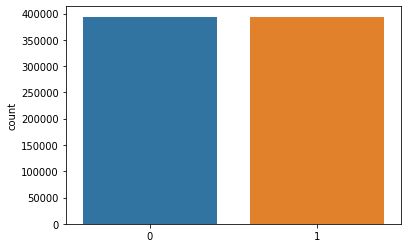

In [ ]:
sns.countplot(y_smote)

In [ ]:
xgb = XGBClassifier(silent = True, eval_metric="logloss")
xgb = xgb.fit(x_train, y_train)
pred = xgb.predict_proba(x_test)
y = pd.DataFrame(pred)
print(y.shape)
y.head()
# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 20)

# print("XGBoost's Accuracy score:", overall__stratified_score(xgb, X_smote, y_smote))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(114038, 2)


,0,1
0,0.992825,0.007175
1,0.855912,0.144088
2,0.998159,0.001841
3,0.972175,0.027825
4,0.956485,0.043515


In [ ]:
y['user_id'] = ids
y = y.drop([0], axis = 1)
y.columns = ['CHURN', 'user_id']
y = y[['user_id',  'CHURN']]
y.to_csv('smote.csv', index = False)
y.shape

(114038, 2)

In [ ]:
print(y_smote.shape)
X_smote.shape

(787784,)


(787784, 142)

In [ ]:
from lightgbm import LGBMClassifier
# import time
# ts = time.time()
lgb = LGBMClassifier()
# print("lgbm's Accuracy score:", overall__stratified_score(lgb, X_smote, y_smote))
# time.time() - ts

In [ ]:
lgb = LGBMClassifier()
lgb = lgb.fit(x_train, y_train.values.ravel())
pred = lgb.predict_proba(x_test)
y = pd.DataFrame(pred)
print(y.shape)
y.head()

(114038, 2)


,0,1
0,0.994983,0.005017
1,0.954899,0.045101
2,0.999158,0.000842
3,0.970388,0.029612
4,0.972361,0.027639


In [ ]:
y['user_id'] = ids
y = y.drop([0], axis = 1)
y.head()

,1,user_id
0,0.005017,c1b31e7cef249f2b777d934886b787a433029263
1,0.045101,c205f3aff8486b0bed1051f3bf25fe04df7f671e
2,0.000842,d743faaf50bbc43e02a08a2c2f4326f6d368fb25
3,0.029612,c4e45ed21d5e2f64146b95fecbbb6b24740f803c
4,0.027639,96c6a822243654ae1fe5f5f887089681f806cb46


In [ ]:
y.columns = ['CHURN', 'user_id']
y = y[['user_id',  'CHURN']]
y.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0.005017
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0.045101
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0.000842
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0.029612
4,96c6a822243654ae1fe5f5f887089681f806cb46,0.027639


In [ ]:
y.loc[y.user_id == '8325a2d68f9431976ce1f6be6fb2e373fdf1b06f']

,user_id,CHURN
46842,8325a2d68f9431976ce1f6be6fb2e373fdf1b06f,0.45592


In [ ]:
y.to_csv('gen.csv', index = False)

In [ ]:
y.shape

(114038, 2)